In [1]:
import os.path as osp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from collections import defaultdict
import os
import re
import sys
from itertools import product
from tqdm.auto import tqdm
sys.path.append('../analyzing_annotations')

ann_embedding_dir = osp.abspath('../scenegram_data/static_encodings')
pred_dir = osp.abspath('../predicted_data/processed')
pred_embedding_dir = osp.join(pred_dir, 'static_encodings')

fig_out_dir = osp.abspath(osp.join(os.pardir, 'collected_data', 'figures', 'vector_similarity'))
if not osp.isdir(fig_out_dir):
    os.makedirs(fig_out_dir)
    
sns.set_theme(style="ticks")

In [2]:
def norm_cos(cos):
    return 2.5 * max(cos, 0)

In [3]:
emb_model_name = 'cn'  # cn or glove

In [4]:
# load predictions
input_file = osp.join(pred_dir, f'processed_predictions_twostep.csv')
pred_df = pd.read_csv(input_file, index_col=0)
pred_df = pred_df.set_index(['tangram', 'scene'])

response_cols = [c for c in pred_df.columns if c.startswith('response_')]
models = [c.replace('response_', '') for c in response_cols]
models = sorted(models, key=lambda x: int(re.search(r'(\d+)', x).group()))

# sets and maps for tangrams / scenes
tangrams, scenes = zip(*pred_df.index)
tangrams = sorted(set(tangrams))
scenes = sorted(set(scenes))
tangram2idx = {t:i for i, t in enumerate(tangrams)}
idx2tangram = {i:t for t, i in tangram2idx.items()}

In [5]:
# load embeddings
ann_emb_file = np.load(osp.join(pred_embedding_dir, f'processed_predictions_twostep_{emb_model_name}_embeddings.npz'), allow_pickle=True)
img_emb_file = np.load(osp.join(ann_embedding_dir, f'scene_{emb_model_name}_embeddings.npz'), allow_pickle=True)

print('ann_emb_file entries: ', '; '.join(ann_emb_file.files))
print('img_emb_file entries: ', '; '.join(img_emb_file.files))

img_idx, img_emb = img_emb_file['img_idx'], img_emb_file['img_emb']
scene_img_embs = dict()
for scene in scenes:  
    # average embeddings for scene images 
    # to get one set of features per scene type
    mask = np.array([scene in i for i in img_idx])
    embs = img_emb[mask]
    mean_emb = img_emb[mask].mean(axis=0)
    scene_img_embs[scene] = mean_emb
    
text_idx = ann_emb_file['text_idx']
text_idx_df = pd.DataFrame(text_idx, columns=['identifyer'])
text_idx_df = pd.merge(
    text_idx_df, 
    pred_df.reset_index().set_index('item_identifyer')[['tangram', 'scene']],
    left_on='identifyer',
    right_index=True
)

ann_emb_file entries:  text_idx; response_llava-13b; label_llava-13b; response_llava-7b; label_llava-7b; response_llava-34b; label_llava-34b; response_llava-72b; label_llava-72b
img_emb_file entries:  img_idx; img_emb


In [6]:
models

['llava-7b', 'llava-13b', 'llava-34b', 'llava-72b']

In [7]:
condition = 'label'
norm = True
_df = pred_df.reset_index()

combinations = list(product(tangrams, scenes))

all_results = dict()
errors = []

for model in tqdm(models):
    
    item_results = defaultdict(dict)
        
    for tangram, scene in tqdm(combinations):
        
        # retrieve text embeddings for contextualized anns
        scene_anns = _df.loc[np.logical_and(_df.tangram == tangram, _df.scene == scene)]
        scene_identifyer = scene_anns.item_identifyer.values
        item_mask = text_idx_df.identifyer.isin(scene_identifyer)
        context_text_emb = ann_emb_file[f'{condition}_{model}'][item_mask]
        # mask out nan
        mask = ~np.array([np.isnan(c).any() for c in context_text_emb])
        context_text_emb = context_text_emb[mask]
        
        # retrieve text embeddings for baseline anns
        baseline_anns = _df.loc[np.logical_and(_df.tangram == tangram, _df.scene == 'none')]
        baseline_identifyer = baseline_anns.item_identifyer.values
        item_mask = text_idx_df.identifyer.isin(baseline_identifyer)
        baseline_text_emb = ann_emb_file[f'{condition}_{model}'][item_mask]
        # mask out nan
        mask = ~np.array([np.isnan(c).any() for c in baseline_text_emb])
        baseline_text_emb = baseline_text_emb[mask]
        
        # retrieve img embs
        scene_img_emb = scene_img_embs[scene].reshape(1, -1)
        
        ###############################
        # compute COHERENCE and SHIFT #
        ###############################
        
        if not (context_text_emb.shape[0] > 0 and baseline_text_emb.shape[0] > 0):
            # if the model didn't produce any meaningful results
            errors.append(
                (model, tangram, scene, context_text_emb.shape[0], baseline_text_emb.shape[0])
            )
            continue
        
        # compute cosine similarities between text and "image" embeddings
        context_cos = cosine_similarity(context_text_emb, scene_img_emb)
        baseline_cos = cosine_similarity(baseline_text_emb, scene_img_emb)
        
        # normalize
        norm_context_cos = np.vstack(list(map(norm_cos, context_cos)))
        norm_baseline_cos = np.vstack(list(map(norm_cos, baseline_cos)))
        
        # mean -> COHERENCE scores
        ic_coherence = norm_context_cos.mean()
        bl_coherence = norm_baseline_cos.mean()
        
        # In-Context Coherence - Baseline Coherence = SHIFT scores
        shift = ic_coherence - bl_coherence
        
        item_results[(tangram, scene)]['In-Context COHERENCE'] = ic_coherence
        item_results[(tangram, scene)]['Baseline COHERENCE'] = bl_coherence
        item_results[(tangram, scene)]['SHIFT'] = shift
        
    per_item_results = pd.DataFrame(item_results).T
    per_item_results.index.names = ['tangram', 'scene']
    
    all_results[model] = per_item_results

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

  0%|          | 0/407 [00:00<?, ?it/s]

In [8]:
errors

[('llava-72b', 'page1-128', 'bathroom', 10, 0),
 ('llava-72b', 'page1-128', 'beach', 10, 0),
 ('llava-72b', 'page1-128', 'bedroom', 10, 0),
 ('llava-72b', 'page1-128', 'forest', 10, 0),
 ('llava-72b', 'page1-128', 'kitchen', 10, 0),
 ('llava-72b', 'page1-128', 'mountain', 10, 0),
 ('llava-72b', 'page1-128', 'none', 0, 0),
 ('llava-72b', 'page1-128', 'office', 10, 0),
 ('llava-72b', 'page1-128', 'sea_bottom', 10, 0),
 ('llava-72b', 'page1-128', 'sky', 10, 0),
 ('llava-72b', 'page1-128', 'street', 10, 0),
 ('llava-72b', 'page8-159', 'bathroom', 10, 0),
 ('llava-72b', 'page8-159', 'beach', 10, 0),
 ('llava-72b', 'page8-159', 'bedroom', 10, 0),
 ('llava-72b', 'page8-159', 'forest', 10, 0),
 ('llava-72b', 'page8-159', 'kitchen', 10, 0),
 ('llava-72b', 'page8-159', 'mountain', 10, 0),
 ('llava-72b', 'page8-159', 'none', 0, 0),
 ('llava-72b', 'page8-159', 'office', 10, 0),
 ('llava-72b', 'page8-159', 'sea_bottom', 10, 0),
 ('llava-72b', 'page8-159', 'sky', 10, 0),
 ('llava-72b', 'page8-159', 

# COHERENCE Plots (Figure 5)

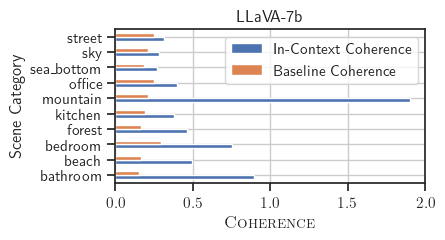

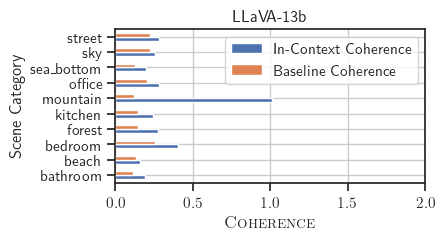

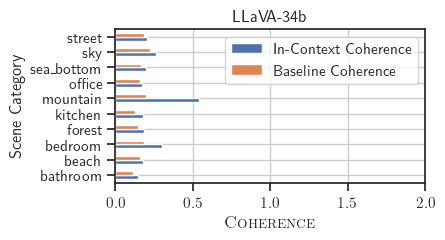

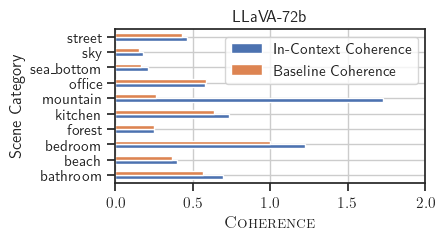

In [9]:
for model in models:
    model_results = all_results[model]
    
    results = defaultdict(dict)

    _r = model_results.reset_index()
    _r = _r.loc[_r.scene != 'none']  # exclude baseline category, since in-context and baseline coherence are equal by definition

    # average over scenes
    for scene in pd.unique(_r.scene):
        results[scene]['In-Context Coherence'] = _r.loc[_r.scene == scene]['In-Context COHERENCE'].mean()
        results[scene]['Baseline Coherence'] = _r.loc[_r.scene == scene]['Baseline COHERENCE'].mean()
        
    plt.rcParams['text.usetex'] = True

    pd.DataFrame(results).T.plot(kind='barh', figsize=(4,2))
    plt.grid()
    plt.title(f'{model.replace("llava", "LLaVA")}')# - GloVe' if emb_model_name == 'glove' else f'{model} - ConceptNet Numberbatch')
    plt.ylabel('Scene Category')
    plt.xlabel(r'\textsc{Coherence}')
    plt.xlim((0,2))

    fname = f'{emb_model_name}_{model}_similarities.png'
    out_path = osp.join(fig_out_dir, fname)
    plt.savefig(out_path, bbox_inches='tight')
    plt.show()